# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
!pip install tqdm pandarallel transformers wordcloud ipywidgets Pillow

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [3]:
import pandas as pd
import transformers
import numpy as np
import torch

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import tensorflow as tf
from PIL import Image

from os import listdir

from transformers import AutoFeatureExtractor, ResNetForImageClassification

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Flatten, Dense, AvgPool2D, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm


tqdm.pandas()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


2023-08-19 16:24:10.374927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 16:24:11.654914: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-08-19 16:24:11.655010: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-08-19 16:24:11.657918: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-08-19 16:24:12.004539: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [4]:
ORIGINAL_DIR = './original'

## Подготовка данных разметки

In [5]:
crowd_annotations = pd.read_csv(f'{ORIGINAL_DIR}/CrowdAnnotations.tsv', delimiter='\t', header=None)
crowd_annotations.columns = ['image', 'query_id', 'percent', 'positive', 'negative']

In [6]:
expert_annotations = pd.read_csv(f'{ORIGINAL_DIR}/ExpertAnnotations.tsv', delimiter='\t', header=None)
expert_annotations.columns = ['image', 'query_id', 'expert_0', 'expert_1', 'expert_2']

In [7]:
def get_expert(record):
    marks = [0, 0, 0, 0]
     
    marks[record['expert_0'] - 1] += 1
    marks[record['expert_1'] - 1] += 1
    marks[record['expert_2'] - 1] += 1

    for i in range(len(marks)):
        if (marks[i] == 2) | (marks[i] == 3):
            return i + 1

    return 0

expert_annotations['mark'] = expert_annotations.apply(get_expert, axis=1)

In [8]:
expert_annotations = expert_annotations[expert_annotations['mark'] > 0]

In [9]:
expert_annotations['percent_expert'] = expert_annotations['mark'] / 4

In [10]:
expert_annotations

,image,query_id,expert_0,expert_1,expert_2,mark,percent_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1,0.25
...,...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1,0.25
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.25
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.25
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1,0.25


In [11]:
crowd_annotations['sum'] = crowd_annotations['positive'] + crowd_annotations['negative']

In [12]:
crowd_annotations['percent_crowd'] = crowd_annotations['positive'] / crowd_annotations['sum']

In [13]:
crowd_annotations

,image,query_id,percent,positive,negative,sum,percent_crowd
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0,3,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3,3,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3,3,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3,3,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3,3,0.000000
...,...,...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3,3,0.000000
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2,3,0.333333
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0,3,1.000000
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3,3,0.000000


In [14]:
expert_annotations

,image,query_id,expert_0,expert_1,expert_2,mark,percent_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1,0.25
...,...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1,0.25
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.25
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.25
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1,0.25


In [15]:
marks = crowd_annotations.merge(expert_annotations, on=['query_id', 'image'])[['image', 'query_id', 'percent_crowd', 'percent_expert']]

## Данные о фотографиях.

In [16]:
test_images = pd.read_csv(f'{ORIGINAL_DIR}/test_images.csv')
test_queries = pd.read_csv(f'{ORIGINAL_DIR}/test_queries.csv', delimiter='|', index_col=[0])
train_dataset = pd.read_csv(f'{ORIGINAL_DIR}/train_dataset.csv')

In [17]:
test_images.sample(10)

,image
99,2346402952_e47d0065b6.jpg
46,3351418768_596ef7fd6f.jpg
62,3119913014_688d4997d7.jpg
24,3421547427_53411b6278.jpg
88,3262849619_0bc4f88ef9.jpg
54,2714674623_8cd05ac114.jpg
53,3553476195_fb3747d7c1.jpg
13,3438981089_2ef1a6353c.jpg
40,3466891862_9afde75568.jpg
71,607339469_af851c4119.jpg


In [18]:
test_queries.sample(10)

,query_id,query_text,image
40,186346360_541047336f.jpg#0,A girl in a bikini top and shorts poses for a ...,186346360_541047336f.jpg
212,3044359043_627488ddf0.jpg#2,A dog jumping off a dock into a pool of water .,3044359043_627488ddf0.jpg
27,1468389504_c724bdcad0.jpg#2,Two little girls in pink outfits play on a yel...,1468389504_c724bdcad0.jpg
134,2517284816_9b8fd3c6b6.jpg#4,Middle school aged kids are showing their scho...,2517284816_9b8fd3c6b6.jpg
28,1468389504_c724bdcad0.jpg#3,Two young girls on a playground .,1468389504_c724bdcad0.jpg
57,2060031241_a3ae7a06bb.jpg#2,A little kid holds up a remote control in fron...,2060031241_a3ae7a06bb.jpg
448,572618443_647483ca82.jpg#3,Two boys playing in water .,572618443_647483ca82.jpg
265,3184031654_34b5c4ffe1.jpg#0,The middle eastern woman wearing the pink head...,3184031654_34b5c4ffe1.jpg
219,3044745642_1d0784ff29.jpg#4,Two people in a tent near a rock wall .,3044745642_1d0784ff29.jpg
224,3089107423_81a24eaf18.jpg#4,The man in the black shirt is pointing his cam...,3089107423_81a24eaf18.jpg


In [19]:
train_dataset.sample(10)

,image,query_id,query_text
310,2909875716_25c8652614.jpg,2534502836_7a75305655.jpg#2,A small brown and white dog running through ta...
2642,300314926_0b2e4b64f5.jpg,3641022607_e7a5455d6c.jpg#2,A man wakeboards on choppy water .
317,2860872588_f2c7b30e1a.jpg,348380010_33bb0599ef.jpg#2,A brown dog with a tennis ball its mouth rolli...
4104,3564312955_716e86c48b.jpg,2647049174_0fb47cee2e.jpg#2,A small child squats and puts dirt into his mo...
5020,2496370758_a3fbc49837.jpg,261490838_2f3ac98b12.jpg#2,A dog chasing a deer in a field of yellow flow...
4950,3325497914_f9014d615b.jpg,3657016761_d553e514d9.jpg#2,A young girl stands under three large rings th...
3485,2373234213_4ebe9c4ee5.jpg,3072114570_e1c0127529.jpg#2,Two boys with backpacks ride bikes through a p...
159,3692892751_f6574e2700.jpg,1536774449_e16b1b6382.jpg#2,A crowd of people at an outdoor event
4286,2966552760_e65b22cd26.jpg,3320032226_63390d74a6.jpg#2,A little girl in a red snowsuit sits on a snow...
3314,219301555_17883a51bd.jpg,3214885227_2be09e7cfb.jpg#2,A person is riding in a canoe on a lake next t...


In [20]:
test_images.info()
print()
test_queries.info()
print()
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [21]:
len(test_queries['image'].unique())

100

In [22]:
len(train_dataset['image'].unique())

1000

In [23]:
test_queries['type'] = 'test'
train_dataset['type'] = 'train'
data = pd.concat([test_queries, train_dataset]).reset_index(drop=True)

In [24]:
len(data['image'].unique())

1100

Проверим test_images и test_queries, соответствуют ли данные, если да то test_images не нужны.

In [25]:
test_queries[test_queries['image'].isin(test_images['image'])]

,query_id,query_text,image,type
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,test
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,test
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,test
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,test
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,test
...,...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg,test
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg,test
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg,test
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg,test


In [26]:
test_images[test_images['image'].isin(test_queries['image'].unique())]

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
...,...
95,2431120202_b24fe2333a.jpg
96,2399219552_bbba0a9a59.jpg
97,3091962081_194f2f3bd4.jpg
98,2670637584_d96efb8afa.jpg


Значит датасеты совпадают

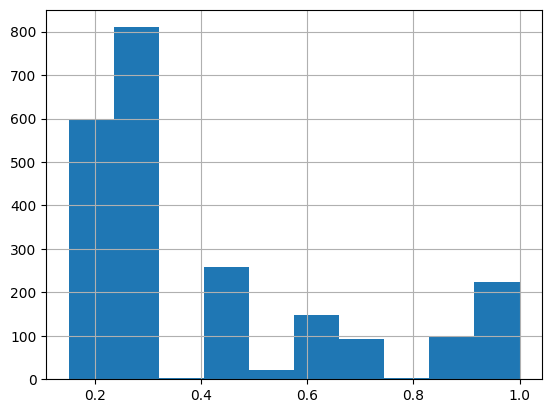

In [27]:
def get_mark(record):
    return record['percent_crowd'] * 0.4 + record['percent_expert'] * 0.6

marks['target'] = marks.apply(get_mark, axis=1)
marks['target'].hist()
None

In [28]:
data['type'].value_counts()

type
train    5822
test      500
Name: count, dtype: int64

In [29]:
df = marks.merge(data, on=['query_id', 'image'], how='right')
df.sample(10)

,image,query_id,percent_crowd,percent_expert,target,query_text,type
4093,2078311270_f01c9eaf4c.jpg,2415803492_56a673dc25.jpg#2,NaN,NaN,NaN,A man in a suit dances with a young girl in fr...,train
3020,2938747424_64e64784f0.jpg,3498327617_d2e3db3ee3.jpg#2,NaN,NaN,NaN,a grey dog swimming through a river with a sti...,train
791,3004823335_9b82cbd8a7.jpg,229862312_1a0ba19dab.jpg#2,0.000000,0.50,0.300000,A dog rolling in the grass .,train
2466,3364151356_eecd07a23e.jpg,2676764246_c58205a365.jpg#2,0.333333,0.50,0.433333,Three dogs running on a racing track .,train
5525,524105255_b346f288be.jpg,3099923914_fd450f6d51.jpg#2,NaN,NaN,NaN,People are enjoying drinks at a table outside ...,train
2468,1394368714_3bc7c19969.jpg,3339140382_2e49bc324a.jpg#2,NaN,NaN,NaN,Three skydivers are in formation above the clo...,train
4298,2105756457_a100d8434e.jpg,2495931537_9b8d4474b6.jpg#2,NaN,NaN,NaN,Dog sniffing another dog lying under furniture .,train
1488,2890113532_ab2003d74e.jpg,3009644534_992e9ea2a7.jpg#2,0.333333,0.50,0.433333,A dog fetches a ball in a field .,train
1444,1554713437_61b64527dd.jpg,3593392955_a4125087f6.jpg#2,NaN,NaN,NaN,Two dogs run down a dirt path in the forest .,train
4752,2225231022_1632d0a5aa.jpg,2712787899_d85048eb6a.jpg#2,0.000000,0.25,0.150000,A young woman sitting on a ledge with a black ...,train


In [30]:
df = df[(~df['percent_crowd'].isna()) | (df['type'] == 'test')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2758 entries, 0 to 6320
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           2758 non-null   object 
 1   query_id        2758 non-null   object 
 2   percent_crowd   2258 non-null   float64
 3   percent_expert  2258 non-null   float64
 4   target          2258 non-null   float64
 5   query_text      2758 non-null   object 
 6   type            2758 non-null   object 
dtypes: float64(3), object(4)
memory usage: 172.4+ KB


## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [31]:
MAX_LENGTH = max(df['query_text'].apply(lambda x: len(x)))
print(MAX_LENGTH)

153


In [32]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

# train_df['query_text'].apply(lambda x: np.array(tokenizer.encode(x, padding='max_length')))

illegal_ids = tokenizer.encode(
    ' '.join(['boy', 'boys', 'girl', 'girls', 'young', 'child', 'children']), 
    truncation=True, 
    max_length=MAX_LENGTH, 
    add_special_tokens=True
)

def tokenize(text, tokenizer, max_length, illegal_ids):
    ids = tokenizer.encode(
        text, 
        truncation=True, 
        # max_length=max_length, 
        padding='max_length',
        add_special_tokens=True
    )
    # print(ids, illegal_ids)
    if len(list(set(ids) & set(illegal_ids))) == 2:
        return [x / tokenizer.vocab_size for x in ids]
    else:
        return None

# def get_padded_mask(tokenized):
#     max_len = 0
#     for i in tokenized.values:
#         if len(i) > max_len:
#             max_len = len(i)

#     padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
#     attention_mask = np.where(padded != 0, 1, 0)

#     padded = torch.LongTensor(padded)  
#     attention_mask = torch.LongTensor(attention_mask)

#     return padded, attention_mask

In [33]:
tokenized = df['query_text'].parallel_apply(tokenize, tokenizer=tokenizer, max_length=MAX_LENGTH, illegal_ids=illegal_ids)

tokenized = tokenized.dropna()

# padded, attention_mask = get_padded_mask(tokenized)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [34]:
df = df.loc[tokenized.index]
df['input_ids'] = tokenized.tolist()
# df['input_ids'] =padded.tolist()
# df['attention_mask'] = attention_mask.tolist()

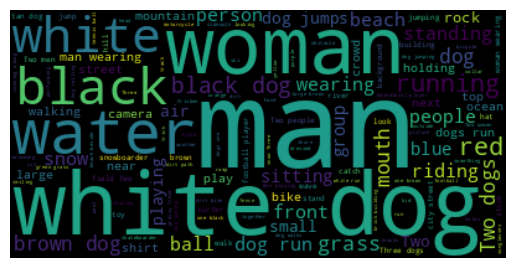

In [35]:
wordcloud = WordCloud().generate(' '.join(df['query_text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
df = df.reset_index(drop=True)

In [37]:
df

,image,query_id,percent_crowd,percent_expert,target,query_text,type,input_ids
0,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,NaN,NaN,NaN,Several female lacrosse players are going afte...,test,"[0.003309088526308892, 0.07191533975493086, 0...."
1,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#3,NaN,NaN,NaN,The woman lacrosse player in blue is about to ...,test,"[0.003309088526308892, 0.06539545246052028, 0...."
2,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#4,NaN,NaN,NaN,Women play lacrosse .,test,"[0.003309088526308892, 0.07561758731406854, 0...."
3,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#0,NaN,NaN,NaN,A brown dog is sitting in some long grass .,test,"[0.003309088526308892, 0.033975493086953676, 0..."
4,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#1,NaN,NaN,NaN,A brown dog sits still on a hillside .,test,"[0.003309088526308892, 0.033975493086953676, 0..."
...,...,...,...,...,...,...,...,...
2103,415793623_6c1225ae27.jpg,2554081584_233bdf289a.jpg#2,0.0,0.50,0.30,a man wearing a yellow shirt and white hardhat...,train,"[0.003309088526308892, 0.033975493086953676, 0..."
2104,476759700_8911f087f8.jpg,1082379191_ec1e53f996.jpg#2,0.0,0.25,0.15,A man and a woman sitting on a dock .,train,"[0.003309088526308892, 0.033975493086953676, 0..."
2105,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,0.0,0.50,0.30,A man stands at the entrance of Yerba Buena Ce...,train,"[0.003309088526308892, 0.033975493086953676, 0..."
2106,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,0.0,0.25,0.15,Two men in black jackets behind a white handra...,train,"[0.003309088526308892, 0.06709914160277833, 0...."


## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [38]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.__version__

Num GPUs Available:  1


'2.10.0'

In [39]:
model = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3), pooling='max')

def read_img_file(f):
    img = Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def resize_img_to_array(img, img_shape):
    img_array = np.array(
        img.resize(
            img_shape,
            Image.LANCZOS
        )
    )    
    return img_array

def get_features(img):
    img_width, img_height = 224, 224
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    expanded_img_array = np.expand_dims(np_img, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    X_conv = model.predict(preprocessed_img, verbose=0)
    # return X_conv
    image_features=X_conv[0]
    image_features /=  np.linalg.norm(image_features)
    return image_features
    

2023-08-19 16:24:16.212327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 16:24:16.213807: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3070)
2023-08-19 16:24:16.397641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-19 16:24:16.397690: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-08-19 16:24:16.397716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [40]:
images = pd.DataFrame(listdir(f'{ORIGINAL_DIR}/images'), columns=['image'])
images = images[images['image'] != '.DS_Store']

In [42]:
def read_img_features(filename, ORIGINAL_DIR=ORIGINAL_DIR, get_features=get_features):
    image = Image.open(f'{ORIGINAL_DIR}/images/{filename}')
    return get_features(image)
    
images['tensor'] = images['image'].progress_apply(read_img_features, ORIGINAL_DIR=ORIGINAL_DIR, get_features=get_features)

100%|██████████| 1100/1100 [01:38<00:00, 11.11it/s]


## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [43]:
df = df.merge(images, on=['image'])

In [44]:
df['features'] = df.apply(lambda x: np.concatenate([x['input_ids'], x['tensor']]), axis=1)

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [45]:
df

,image,query_id,percent_crowd,percent_expert,target,query_text,type,input_ids,tensor,features
0,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,NaN,NaN,NaN,Several female lacrosse players are going afte...,test,"[0.003309088526308892, 0.07191533975493086, 0....","[0.023832401, 0.03071706, 0.0, 0.022547793, 0....","[0.003309088526308892, 0.07191533975493086, 0...."
1,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#3,NaN,NaN,NaN,The woman lacrosse player in blue is about to ...,test,"[0.003309088526308892, 0.06539545246052028, 0....","[0.023832401, 0.03071706, 0.0, 0.022547793, 0....","[0.003309088526308892, 0.06539545246052028, 0...."
2,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#4,NaN,NaN,NaN,Women play lacrosse .,test,"[0.003309088526308892, 0.07561758731406854, 0....","[0.023832401, 0.03071706, 0.0, 0.022547793, 0....","[0.003309088526308892, 0.07561758731406854, 0...."
3,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#0,NaN,NaN,NaN,A brown dog is sitting in some long grass .,test,"[0.003309088526308892, 0.033975493086953676, 0...","[0.00822476, 0.014956112, 0.012222196, 0.01061...","[0.003309088526308892, 0.033975493086953676, 0..."
4,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#1,NaN,NaN,NaN,A brown dog sits still on a hillside .,test,"[0.003309088526308892, 0.033975493086953676, 0...","[0.00822476, 0.014956112, 0.012222196, 0.01061...","[0.003309088526308892, 0.033975493086953676, 0..."
...,...,...,...,...,...,...,...,...,...,...
2103,3191135894_2b4bdabb6d.jpg,1490213660_9ea45550cf.jpg#2,0.000000,0.25,0.150000,A male weimaraner with a clipped tail is walki...,train,"[0.003309088526308892, 0.033975493086953676, 0...","[0.0045584976, 0.006491686, 0.008002392, 0.037...","[0.003309088526308892, 0.033975493086953676, 0..."
2104,3399284917_721aefe2a7.jpg,3085667865_fa001816be.jpg#2,0.000000,0.25,0.150000,A person in a wetsuit is in midair while surfi...,train,"[0.003309088526308892, 0.033975493086953676, 0...","[0.008116325, 0.016763875, 0.0, 0.038178343, 0...","[0.003309088526308892, 0.033975493086953676, 0..."
2105,3484832904_08619300d9.jpg,3542484764_77d8920ec9.jpg#2,0.666667,0.75,0.716667,The cricketer is swinging a bat in the air .,train,"[0.003309088526308892, 0.06539545246052028, 0....","[0.011006555, 0.012909047, 0.0, 0.03232149, 0....","[0.003309088526308892, 0.06539545246052028, 0...."
2106,754852108_72f80d421f.jpg,2162564553_96de62c7e6.jpg#2,0.000000,0.50,0.300000,A shirtless man in a pink hat stands on a rock...,train,"[0.003309088526308892, 0.033975493086953676, 0...","[0.006191542, 0.025581887, 0.0026996569, 0.013...","[0.003309088526308892, 0.033975493086953676, 0..."


In [84]:
valid_df = df[df['type'] == 'test'].reset_index(drop=True)

In [54]:
train_test_df = df[df['type'] == 'train'].reset_index(drop=True)

In [48]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=train_test_df[['input_ids', 'tensor']], y=train_test_df['target'], groups=train_test_df['image']))
train_df, test_df = train_test_df.loc[train_indices], train_test_df.loc[test_indices]

In [55]:
model = Sequential()
model.add(Dense(MAX_LENGTH+2048, activation='relu'))
# model.add(Dropout(.2))
# model.add(GlobalAveragePooling2D())
model.add(Dense(units=1, activation='relu'))

optimizer = Adam(learning_rate=0.0005) 

model.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])



In [57]:
model.fit(pd.DataFrame(train_test_df['features'].to_list()).add_prefix('feature_'), train_test_df['target'], batch_size=32, epochs=10)

Epoch 1/10
 3/56 [>.............................] - ETA: 2s - loss: 0.1234 - mean_absolute_error: 0.3056 

2023-08-19 16:26:53.825827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-19 16:26:53.878342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-19 16:26:53.878417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 21482 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


56/56 [==============================] - 1s 13ms/step - loss: 0.0758 - mean_absolute_error: 0.2191
Epoch 2/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0622 - mean_absolute_error: 0.1945
Epoch 3/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0575 - mean_absolute_error: 0.1883
Epoch 4/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0535 - mean_absolute_error: 0.1791
Epoch 5/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0523 - mean_absolute_error: 0.1775
Epoch 6/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0526 - mean_absolute_error: 0.1776
Epoch 7/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0438 - mean_absolute_error: 0.1604
Epoch 8/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0445 - mean_absolute_error: 0.1621
Epoch 9/10
56/56 [==============================] - 1s 11ms/step - loss: 0.0426 - mean_absolute_error: 0.1575
Epoch 10/10
56/56 [==

In [61]:
y_true = list(test_df['target'])

In [66]:
y_pred = model.predict(pd.DataFrame(test_df['features'].to_list()).add_prefix('feature_'))

17/17 [==============================] - 0s 7ms/step


In [79]:
print(f'MAE тестовой {mean_absolute_error(y_true, y_pred)}')

MAE тестовой 0.14412254912278322


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [107]:
valid_img_tensor = valid_df[valid_df['image'].isin(test_images['image'])][['image', 'tensor']].drop_duplicates(['image'])

In [106]:
valid_text_ids = valid_df[valid_df['query_id'].isin(test_queries['query_id'])][['query_text', 'query_id', 'input_ids']]

In [110]:
valid_img_tensor

,image,tensor
0,123997871_6a9ca987b1.jpg,"[0.023832401, 0.03071706, 0.0, 0.022547793, 0...."
3,1319634306_816f21677f.jpg,"[0.00822476, 0.014956112, 0.012222196, 0.01061..."
8,1429546659_44cb09cbe2.jpg,"[0.003617084, 0.01904719, 0.012432366, 0.00497..."
13,1580671272_3e99d94305.jpg,"[0.0009823483, 0.023684677, 0.00050072785, 0.0..."
16,1745110280_0cbff5e273.jpg,"[0.00216748, 0.0013565266, 0.005050751, 0.0, 0..."
...,...,...
328,862156271_3eacea90a8.jpg,"[0.0137445005, 0.019698737, 0.0, 0.02070524, 0..."
329,862177617_c2c0581075.jpg,"[0.022053204, 0.025099387, 0.0009458218, 0.035..."
333,957682378_46c3b07bcd.jpg,"[0.009084037, 0.0070669195, 0.01299478, 0.0, 0..."
338,973827791_467d83986e.jpg,"[0.001524387, 0.0, 0.017453024, 0.0185956, 0.0..."


In [109]:
valid_text_ids

,query_text,query_id,input_ids
0,Several female lacrosse players are going afte...,123997871_6a9ca987b1.jpg#1,"[0.003309088526308892, 0.07191533975493086, 0...."
1,The woman lacrosse player in blue is about to ...,123997871_6a9ca987b1.jpg#3,"[0.003309088526308892, 0.06539545246052028, 0...."
2,Women play lacrosse .,123997871_6a9ca987b1.jpg#4,"[0.003309088526308892, 0.07561758731406854, 0...."
3,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg#0,"[0.003309088526308892, 0.033975493086953676, 0..."
4,A brown dog sits still on a hillside .,1319634306_816f21677f.jpg#1,"[0.003309088526308892, 0.033975493086953676, 0..."
...,...,...,...
340,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg#0,"[0.003309088526308892, 0.033975493086953676, 0..."
341,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg#1,"[0.003309088526308892, 0.033975493086953676, 0..."
342,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg#2,"[0.003309088526308892, 0.033975493086953676, 0..."
343,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg#3,"[0.003309088526308892, 0.033975493086953676, 0..."


In [114]:
check_df = valid_text_ids.sample(10, random_state=1234).merge(valid_img_tensor, how='cross')
check_df['features'] = check_df.apply(lambda x: np.concatenate([x['input_ids'], x['tensor']]), axis=1)
check_df

,query_text,query_id,input_ids,image,tensor,features
0,Performers performing a play .,3396275223_ee080df8b5.jpg#3,"[0.003309088526308892, 0.31344603892274425, 0....",123997871_6a9ca987b1.jpg,"[0.023832401, 0.03071706, 0.0, 0.022547793, 0....","[0.003309088526308892, 0.31344603892274425, 0...."
1,Performers performing a play .,3396275223_ee080df8b5.jpg#3,"[0.003309088526308892, 0.31344603892274425, 0....",1319634306_816f21677f.jpg,"[0.00822476, 0.014956112, 0.012222196, 0.01061...","[0.003309088526308892, 0.31344603892274425, 0...."
2,Performers performing a play .,3396275223_ee080df8b5.jpg#3,"[0.003309088526308892, 0.31344603892274425, 0....",1429546659_44cb09cbe2.jpg,"[0.003617084, 0.01904719, 0.012432366, 0.00497...","[0.003309088526308892, 0.31344603892274425, 0...."
3,Performers performing a play .,3396275223_ee080df8b5.jpg#3,"[0.003309088526308892, 0.31344603892274425, 0....",1580671272_3e99d94305.jpg,"[0.0009823483, 0.023684677, 0.00050072785, 0.0...","[0.003309088526308892, 0.31344603892274425, 0...."
4,Performers performing a play .,3396275223_ee080df8b5.jpg#3,"[0.003309088526308892, 0.31344603892274425, 0....",1745110280_0cbff5e273.jpg,"[0.00216748, 0.0013565266, 0.005050751, 0.0, 0...","[0.003309088526308892, 0.31344603892274425, 0...."
...,...,...,...,...,...,...
825,The dog is sitting on the side of the hill .,1319634306_816f21677f.jpg#4,"[0.003309088526308892, 0.06539545246052028, 0....",862156271_3eacea90a8.jpg,"[0.0137445005, 0.019698737, 0.0, 0.02070524, 0...","[0.003309088526308892, 0.06539545246052028, 0...."
826,The dog is sitting on the side of the hill .,1319634306_816f21677f.jpg#4,"[0.003309088526308892, 0.06539545246052028, 0....",862177617_c2c0581075.jpg,"[0.022053204, 0.025099387, 0.0009458218, 0.035...","[0.003309088526308892, 0.06539545246052028, 0...."
827,The dog is sitting on the side of the hill .,1319634306_816f21677f.jpg#4,"[0.003309088526308892, 0.06539545246052028, 0....",957682378_46c3b07bcd.jpg,"[0.009084037, 0.0070669195, 0.01299478, 0.0, 0...","[0.003309088526308892, 0.06539545246052028, 0...."
828,The dog is sitting on the side of the hill .,1319634306_816f21677f.jpg#4,"[0.003309088526308892, 0.06539545246052028, 0....",973827791_467d83986e.jpg,"[0.001524387, 0.0, 0.017453024, 0.0185956, 0.0...","[0.003309088526308892, 0.06539545246052028, 0...."


In [116]:
check_df['predict'] = model.predict(pd.DataFrame(check_df['features'].to_list()).add_prefix('feature_'))

26/26 [==============================] - 0s 8ms/step


In [225]:
max_predict_check_df = check_df[check_df.groupby(['query_id'])['predict'].transform(max) == check_df['predict']].reset_index(drop=True)

/tmp/ipykernel_116212/2036827273.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


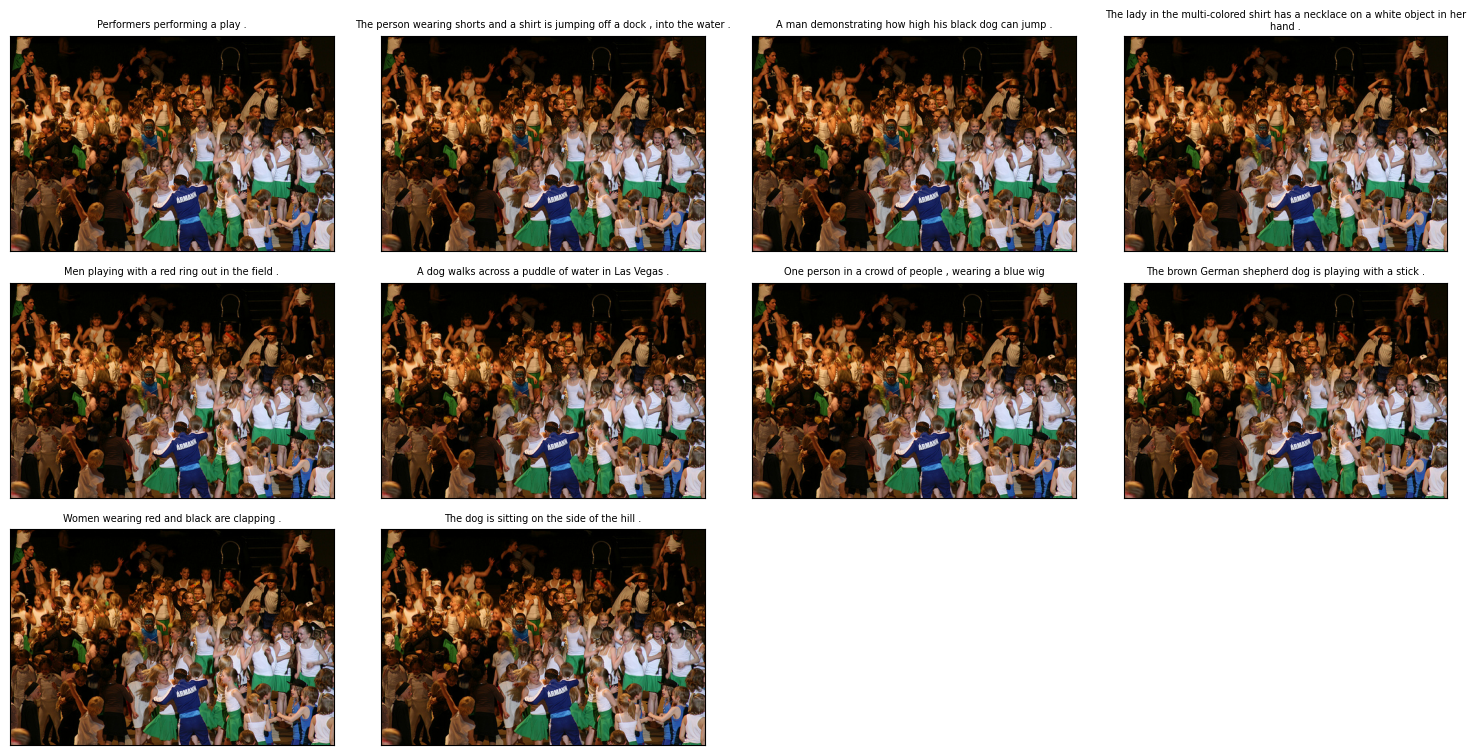

In [235]:
fig = plt.figure(figsize=(15,20))
for i in max_predict_check_df.index:
    fig.add_subplot(8, 4, i+1)
    plt.title(max_predict_check_df.loc[i, 'query_text'], fontsize=7, wrap=True)
    image = Image.open(f'{ORIGINAL_DIR}/images/{record["image"]}')
    plt.imshow(np.array(image)) 
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска